### Install Kaggle API and configure directory to enable Kaggle dataset download

In [1]:
# Download Kaggle API
!pip install kaggle

# Use Token for API validation

import os
import json
USER_ID = 'prafulmaka'
USER_SECRET = ''

KAGGLE_CONFIG_DIR = os.path.join(os.path.expandvars('$HOME'), '.kaggle')
os.makedirs(KAGGLE_CONFIG_DIR, exist_ok=True)
with open(os.path.join(KAGGLE_CONFIG_DIR, 'kaggle.json'), 'w') as f:
    json.dump({'username': USER_ID, 'key': USER_SECRET}, f)
!chmod 600 {KAGGLE_CONFIG_DIR}/kaggle.json

# Download Dataset
!kaggle datasets download -d shivamb/real-or-fake-fake-jobposting-prediction --unzip

    100% |████████████████████████████████| 61kB 2.6MB/s ta 0:00:011
    100% |████████████████████████████████| 81kB 7.2MB/s ta 0:00:011
  Running setup.py bdist_wheel for kaggle ... done
  Stored in directory: /home/mb12/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
  Running setup.py bdist_wheel for python-slugify ... done
  Stored in directory: /home/mb12/.cache/pip/wheels/11/94/81/312969455540cb0e6a773e5d68a73c14128bfdfd4a7969bb4f
Successfully built kaggle python-slugify
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
 87%|█████████████████████████████████     | 14.0M/16.1M [00:00<00:00, 44.8MB/s]
100%|██████████████████████████████████████| 16.1M/16.1M [00:00<00:00, 63.2MB/s]


### This is the Dataset we will be working with:

In [1]:
# Load Dataset
import pandas as pd
df = pd.read_csv("fake_job_postings.csv")


# Check first 5 Rows
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


#### As you can see, there are only 3 features that does not require any transformation. All strings will have to be converted into numerical values. 

#### Since company profile, description, requirements and benefits are columns with long texts, we will combine all text to a single column and transform to numerical values using Embedding.

### Let's explore the dataset in detail and find ways of transformations for each feature

#### These are the missing values/nulls in each feature

Text(0.5, 1.0, 'Missing Data')

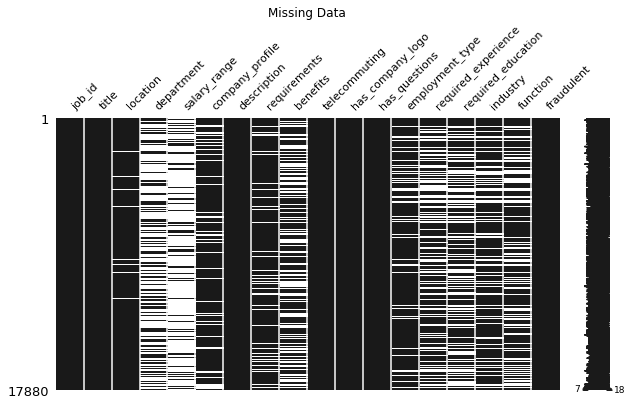

In [3]:
# Check for NaNs/Visualize Missing Data - MissingNo
import missingno
import matplotlib.pyplot as plt
%matplotlib inline
missingno.matrix(df, figsize=(10,5), color=(0.1,0.1,0.1), fontsize=11)
plt.title('Missing Data')

#### This is the count of fraudulent job postings by Industry

industry
Information Technology and Services    1734
Computer Software                      1376
Internet                               1062
Marketing and Advertising               828
Education Management                    822
Name: fraudulent, dtype: int64


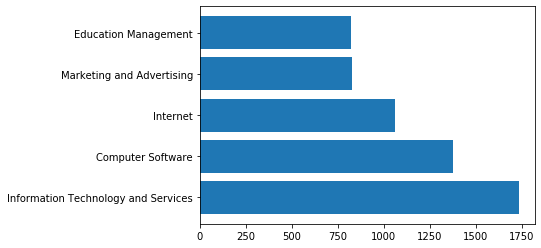

In [4]:
# Lets visualise what are the Top Industries Fraudulent Job Applications are coming from?
import numpy as np
industry_fraud = df['fraudulent'].groupby([df['industry']]).count()
top5 = industry_fraud.sort_values(ascending=False).head(5)
print(top5)

bars = top5.index
height = top5.values
y_pos = np.arange(len(bars))

plt.barh(y_pos, height)
plt.yticks(y_pos, bars)
plt.show()

In [5]:
# Since Job ID is unique for each row, we will drop Job ID since we already have the index
df.drop(columns='job_id', inplace=True)

#### Salary range has about 85% of Null values - we will use this column to create a binary column where NaNs will be 0 and rows with salary details provided will be 1

In [6]:
# Since number of nans in Salary_Range is about 85%, we will create a new column indicating if salary range is mentioned or not
df['salary_mentioned'] = df['salary_range']

# Assign 0 for salary not mentioned and 1 for salary mentioned
df['salary_mentioned'][df['salary_mentioned'].notna()] = 1
df['salary_mentioned'].fillna(0, inplace=True)

# Drop salary_range column since we don't need it now
df.drop(columns='salary_range', inplace=True)

C:\Users\nmaka\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


#### Merge columns with text descriptions to one column for embedding

In [7]:
# Replace Nans to single space to be able to merge columns with strings together 
df['company_profile'] = df['company_profile'].fillna(' ')
df['description'] = df['description'].fillna(' ')
df['requirements'] = df['requirements'].fillna(' ')
df['benefits'] = df['benefits'].fillna(' ')

# Merge to Description
df['description'] = df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits']

# Drop columns since we don't need it now 
df.drop(['company_profile', 'requirements', 'benefits'], axis=1, inplace=True)

# Convert Description strings to lowercase
df['description'] = [x.lower() for x in df['description']]

#### Split country and city from the location column - this would make it easier for us to use categorical codes for this column

In [8]:
# Split Location to Country and City 
df['country'] = df['location'].str.split(',').str[0]

df['city'] = df['location'].str.split(',').str[-1]

# Drop column since we don't need it 
df.drop(columns='location', inplace=True)

#### Populate department column based on function column where NaN since these columns contain identical information. This helps us drop the function column.

In [9]:
# Since Department and Function holds the same details, we will fill in Department using Function wherever required
df['department'].fillna(df.function, inplace=True)

# Drop column since we don't need it 
df.drop(columns='function', inplace=True)

#### Replace NaNs with Unspecified

In [10]:
# Fill Nulls in Required Experience and Required Education
df['required_education'].fillna('Unspecified', inplace=True)
df['required_experience'].fillna('Unspecified', inplace=True)

#### In order to focus on values with most significance and maintain consistency - we will limit number of unique values in each column to maximum 19 high frequency values and convert the rest to "Other"

In [11]:
# Keep top 19 unique values in industry and replace rest by 'Other'
df['industry'][~df['industry'].isin(df['industry'].value_counts().head(19).index)] = 'Other'

C:\Users\nmaka\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
# Keep top 19 unique values in department and replace rest by 'Other'
df['department'][~df['department'].isin(df['department'].value_counts().head(19).index)] = 'Other'

C:\Users\nmaka\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### In a strive to fill missing values as much as possible while maintaining integrity of the original dataset - we fill missing values in employment type to "Other"

In [13]:
# Convert NaNs to Other
df['employment_type'].fillna('Other', inplace=True)

#### Similar to previous steps, we assign all values in Country column which are not in the top 19 as "OT"

In [14]:
# Keep top 19 unique values in country and replace rest by 'Other'
df['country'][~df['country'].isin(df['country'].value_counts().head(19).index)] = 'OT'

C:\Users\nmaka\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### All Cities which are not in top 19 are assigned as "Other"

In [15]:
df['city'][df['city'] == ' '] = ' Other'
df['city'][~df['city'].isin(df['city'].value_counts().head(19).index)] = 'Other'

C:\Users\nmaka\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\nmaka\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Convert all string columns to numeric values using categorical codes

In [16]:
df['department'] = df.department.astype('category').cat.codes
df['employment_type'] = df.employment_type.astype('category').cat.codes
df['required_experience'] = df.required_experience.astype('category').cat.codes
df['required_education'] = df.required_education.astype('category').cat.codes
df['industry'] = df.industry.astype('category').cat.codes
df['city'] = df.city.astype('category').cat.codes
df['country'] = df.country.astype('category').cat.codes

#### Now we have a clean-er dataset with no NaN values

In [17]:
# Check for any NaNs in the dataset
df.isna().sum()

title                  0
department             0
description            0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
fraudulent             0
salary_mentioned       0
country                0
city                   0
dtype: int64

#### Convert all string columns to lowercase and remove punctuations to avoid double-counting

In [18]:
# Convert Description strings to lowercase and remove all punctutations to improve tokenization
import string
df['title'] = [x.lower() for x in df['title']]
df['title'] = df['title'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))
df['description'] = df['description'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

#### This is how our Data looks now:

In [19]:
# Check Dataframe head to ensure all columns have been transformed as specified
df.head()

,title,department,description,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,fraudulent,salary_mentioned,country,city
0,marketing intern,14,were food52 and weve created a groundbreaking ...,0,1,0,2,4,9,15,0,0,19,11
1,customer service cloud video production,16,90 seconds the worlds cloud video production s...,0,1,0,1,6,9,13,0,0,14,2
2,commissioning machinery assistant cma,16,valor services provides workforce solutions th...,0,1,0,2,7,9,15,0,0,19,19
3,account executive washington dc,18,our passion for improving quality of life thro...,0,1,0,1,5,1,1,0,0,19,18
4,bill review manager,9,spotsource solutions llc is a global human cap...,0,1,1,1,5,1,9,0,0,19,19


#### We tokenize and convert all words to vectors using nltk.tokenize

#### First - the Title column

In [20]:
# Title Column. We will only use the top 2000 words out of the 5481 unique words in this column

from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

all_words = []
for sent in df['title']:
    tokenize_word = word_tokenize(sent)
    for word in tokenize_word:
        all_words.append(word)
        
embedded_sentences = [one_hot(sent, 2000) for sent in df['title']]
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(df['title'], key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))
padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')
df['Title_INT'] = padded_sentences.tolist()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nmaka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
len(set(all_words))

5481

#### Second - the Description column

In [22]:
# Description Column. We will use the top 15000 words out of the 168393 unique words in this column. 

all_words1 = []
for sent1 in df['description']:
    tokenize_word1 = word_tokenize(sent1)
    for word1 in tokenize_word1:
        all_words1.append(word1)
            
embedded_sentences1 = [one_hot(sent1, 15000) for sent1 in df['description']]
word_count1 = lambda sentence1: len(word_tokenize(sentence1))
longest_sentence1 = max(df['description'], key=word_count1)
length_long_sentence1 = len(word_tokenize(longest_sentence1))
padded_sentences_1 = pad_sequences(embedded_sentences1, length_long_sentence1, padding='post')
df['Desc_INT'] = (padded_sentences_1).tolist()

In [23]:
len(set(all_words1))

168393

#### WordCloud was an useful library to visualize the most popular keywords amongst Fraudulent and Authentic job postings

Text(0.5,1,'Fraudulent Jobs - Popular Keywords')

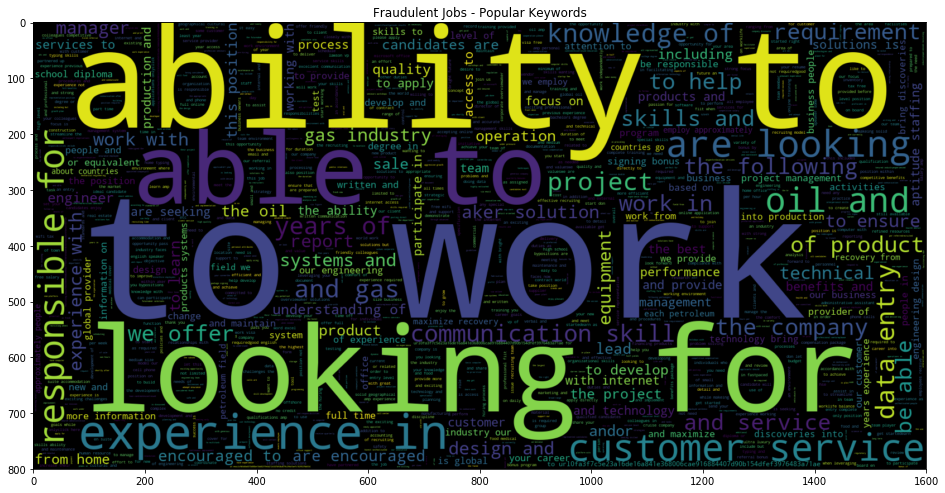

In [45]:
# Lets plot a wordcloud to see what are common words with most occurence in the dataset
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from wordcloud import WordCloud
fraudjobs_text = df[df['fraudulent'] == 1].description
actualjobs_text = df[df['fraudulent'] == 0].description
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')
plt.title('Fraudulent Jobs - Popular Keywords')

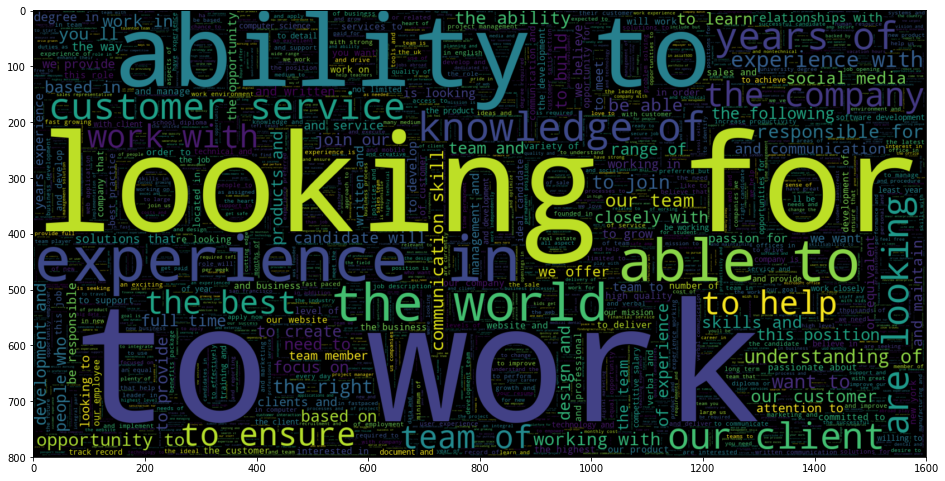

In [46]:
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(actualjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')


# Code Obtained from:
# Shivam Burnwal
# June 24th, 2020
# Title: NLP(98%acc.) EDA with model using Spacy & Pipeline
# https://www.kaggle.com/shivamburnwal/nlp-98-acc-eda-with-model-using-spacy-pipeline

# Data Preparation

#### Now, with description and title converted to vectors, we will add all the numerical data to the vector and make a new dataframe so it is easy to feed the data into different ML models.

In [24]:
# Add other features to the vector
list1 = []
for i in df.index:
    list1.append([df['department'].loc[i], df['telecommuting'].loc[i], df['has_company_logo'].loc[i], df['has_questions'].loc[i], 
                             df['employment_type'].loc[i], df['required_experience'].loc[i], df['required_education'].loc[i], df['industry'].loc[i],
                            df['salary_mentioned'].loc[i], df['country'].loc[i], df['city'].loc[i]])

#### Description and Title column, which are now entirely vectors, are added together

In [26]:
# Merge 2 vectors in 1
list2 = df['Desc_INT'] + df['Title_INT']

In [27]:
len(list2[0])

2163

#### List 2 is added to List 1 

In [29]:
for i in range(17880):
    list1[i].extend(list2[i])

In [30]:
len(list1[0])

4337

#### Let's create a new Data Frame with the two combined Lists and a Labels column

In [31]:
# Create New Dataframe with all features and label
df1 = pd.DataFrame(list1)
df1['Labels'] = df['fraudulent']

In [32]:
# Preview Final 
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,2165,2166,2167,2168,2169,2170,2171,2172,2173,Labels
0,14,0,1,0,2,4,9,15,0,19,...,0,0,0,0,0,0,0,0,0,0
1,16,0,1,0,1,6,9,13,0,14,...,0,0,0,0,0,0,0,0,0,0
2,16,0,1,0,2,7,9,15,0,19,...,0,0,0,0,0,0,0,0,0,0
3,18,0,1,0,1,5,1,1,0,19,...,0,0,0,0,0,0,0,0,0,0
4,9,0,1,1,1,5,1,9,0,19,...,0,0,0,0,0,0,0,0,0,0


#### Lets add the original column names to our all-vector DF

In [33]:
# We will now add column labels to new dataframe in the same order it has been added to the list1. 
# Column labels for description will be 1 to 2145, title will be 2146 to 2163

d = ['department', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience',
     'required_education','industry','salary_mentioned', 'country', 'city']
e = np.arange(1,2164,1)
d.extend(e)
d.append('Labels')
df1.columns = d

In [34]:
df1.head()

,department,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,salary_mentioned,country,...,2155,2156,2157,2158,2159,2160,2161,2162,2163,Labels
0,14,0,1,0,2,4,9,15,0,19,...,0,0,0,0,0,0,0,0,0,0
1,16,0,1,0,1,6,9,13,0,14,...,0,0,0,0,0,0,0,0,0,0
2,16,0,1,0,2,7,9,15,0,19,...,0,0,0,0,0,0,0,0,0,0
3,18,0,1,0,1,5,1,1,0,19,...,0,0,0,0,0,0,0,0,0,0
4,9,0,1,1,1,5,1,9,0,19,...,0,0,0,0,0,0,0,0,0,0


#### The Embedding step padded each row with 0s to ensure the length of each vector is equal

#### These are the columns with all 0s

In [56]:
#Lets check of any columns that may have only spaces (i.e 0)
q = df1.columns[(df1 == 0).all()]
q

Index([2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086,
       2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098,
       2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110,
       2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122,
       2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134,
       2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145],
      dtype='object')

#### We drop these columns as these 0s don't add any value to our models

In [57]:
# As we can see the columns from 2075 to 2145 are only filled with zeros or spaces, we will get rid of these columns as they just
# add noise to the dataset

df2 = df1.drop(columns=q)

#### Now we have the dataset ready to feed to the model.

In [58]:
# We will save master data to a file to avoid computing all above fields in case connection to kernel is lost
df2.to_csv("Master_Data.csv", index = False)

In [59]:
# Upload Dataset Quick
# df2 = pd.read_csv("Master_Data.csv")
# df2.head()

In [60]:
# Set figure size in inches
from matplotlib import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 18,8.27

#### Looks like we are dealing with an Imbalanced Dataset

#### 95% of Labels are 0 while only 5% are 1

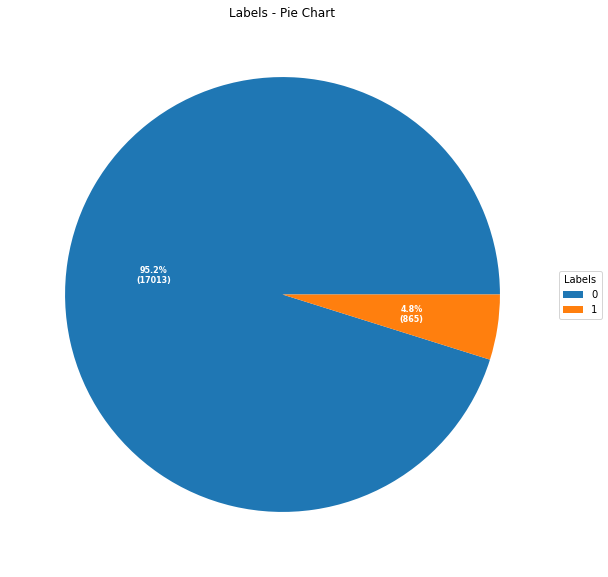

In [61]:
# Lets visualise the label distribution to ensure a balanced dataset

labels_df = df.fraudulent.value_counts()
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))

data = labels_df.values
Labels = labels_df.index

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data), textprops=dict(color="w"))
ax.legend(wedges, Labels, title="Labels", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")
ax.set_title("Labels - Pie Chart")
plt.show()

# 95% of Labels are 0 ; 4.8% are 1

## For Data and Model selection (Includes: PCA, Oversampling, Undersampling and Model Selection) please refer to our other notebook "Model Selection.ipynb".

#### In the "Model Selection.ipynb" notebook we tried PCA, Oversampling and Undersampling on 3 different models - Logistic Regression (Baseline), Deep Neural Networks and Random Forests.


## Model building
## We will use Random Forest Classifier on a oversampled and scaled dataset. We found that Random Forest had the best results and the metric results were better than the other models.


#### Split Data to X and Y

In [62]:
# Lets split features and labels to X and y respectively.

X = df2.drop(columns='Labels')
y = df2['Labels']

#### Standardizing our X data

In [63]:
# Lets scale our features to ensure the objective functions work properly

from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

#### Splitting our data into Train and Test

In [64]:
#Lets split our data into training and testing data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, stratify=y, random_state=66)

#### Using SMOTE (Over-Sampling) to infuse synthetic data points for the minority class 1

In [66]:
# Apply SMOTE on training dataset to infuse synthetic data points for the minority class

from imblearn.over_sampling import SMOTE
print("Counts data points for label '1' is", sum(y_train == 1),'before Oversampling')
print("Counts data points for label '0' is", sum(y_train == 0),'before Oversampling')

X_train_nm, y_train_nm = SMOTE(random_state = 2).fit_sample(X_train, y_train.ravel()) 

print("Counts data points for label '1' is", sum(y_train_nm == 1),'after Oversampling')
print("Counts data points for label '0' is", sum(y_train_nm == 0),'after Oversampling')

Counts data points for label '1' is 606 before undersampling
Counts data points for label '0' is 11910 before undersampling
Counts data points for label '1' is 11910 after undersampling
Counts data points for label '0' is 11910 after undersampling


In [67]:
# Import required libraries for model building and evaluation

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

#### Set up Random Forest Model

In [68]:
# Build a random forest classifier with 500 estimators

rfc = RandomForestClassifier(n_estimators=500)

In [69]:
# Train model using training data

rfc.fit(X_train_nm,y_train_nm)

RandomForestClassifier(n_estimators=500)

#### Result Metrics for Random Forest Model

In [70]:
# Predict Labels
rfc_pred = rfc.predict(X_test)

# Print classification report 
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      5104
           1       0.94      0.49      0.65       260

    accuracy                           0.97      5364
   macro avg       0.96      0.75      0.82      5364
weighted avg       0.97      0.97      0.97      5364



#### Confusion Matrix for Random Forest Model

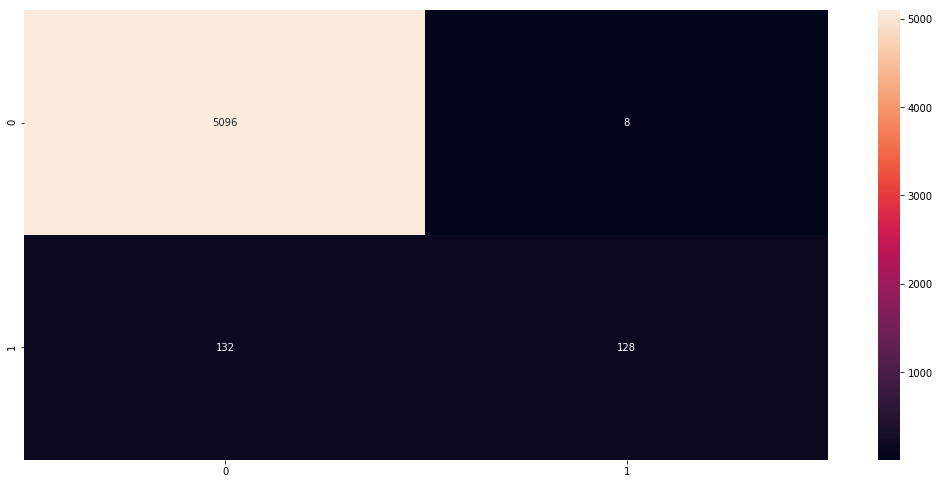

In [71]:
# Plot confusion matrix

c_m_rf = confusion_matrix(y_test, rfc_pred)
sns.heatmap(c_m_rf, annot=True, fmt='d') # font size
plt.show()

#### AUC Score for Random Forest Model

In [72]:
# AUC Score
metrics.roc_auc_score(y_test, rfc_pred)

0.7453701470942851

#### Removing Noise using Random Forest feature importances

In [73]:
# Calculate Feature importance for each feature to remove noise from the dataset and achieve better metrics

# Get numerical feature importances
importances = rfc.feature_importances_
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(df2.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('{} : {}'.format(*pair)) for pair in feature_importances]

has_company_logo : 0.04
has_questions : 0.02
required_education : 0.02
country : 0.02
employment_type : 0.01
industry : 0.01
1 : 0.01
2 : 0.01
3 : 0.01
4 : 0.01
6 : 0.01
7 : 0.01
8 : 0.01
10 : 0.01
11 : 0.01
13 : 0.01
16 : 0.01
21 : 0.01
22 : 0.01
23 : 0.01
24 : 0.01
25 : 0.01
26 : 0.01
31 : 0.01
34 : 0.01
39 : 0.01
41 : 0.01
43 : 0.01
44 : 0.01
47 : 0.01
48 : 0.01
49 : 0.01
51 : 0.01
52 : 0.01
60 : 0.01
69 : 0.01
91 : 0.01
93 : 0.01
2148 : 0.01
department : 0.0
telecommuting : 0.0
required_experience : 0.0
salary_mentioned : 0.0
city : 0.0
5 : 0.0
9 : 0.0
12 : 0.0
14 : 0.0
15 : 0.0
17 : 0.0
18 : 0.0
19 : 0.0
20 : 0.0
27 : 0.0
28 : 0.0
29 : 0.0
30 : 0.0
32 : 0.0
33 : 0.0
35 : 0.0
36 : 0.0
37 : 0.0
38 : 0.0
40 : 0.0
42 : 0.0
45 : 0.0
46 : 0.0
50 : 0.0
53 : 0.0
54 : 0.0
55 : 0.0
56 : 0.0
57 : 0.0
58 : 0.0
59 : 0.0
61 : 0.0
62 : 0.0
63 : 0.0
64 : 0.0
65 : 0.0
66 : 0.0
67 : 0.0
68 : 0.0
70 : 0.0
71 : 0.0
72 : 0.0
73 : 0.0
74 : 0.0
75 : 0.0
76 : 0.0
77 : 0.0
78 : 0.0
79 : 0.0
80 : 0.0
81 : 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

#### Let us consider only the features with Importance > 0

In [74]:
# Choose name of columns from feature importance list where importance is more than 0 and add labels to the list.
m = pd.DataFrame(feature_importances)
m = m[m[1]>0]
m = m[0].values
a = []
for i in m:
    a.append(i)
a.append('Labels')

In [75]:
# As we can see the feature importance dictionary above only few features holds importance whereas the others holds 0
# importance. Lets get rid of the features that hold no importance and train another model.

df3 = df2[a]

#### This is our new DF which only consists of features with Importance > 0

In [76]:
df3.head()

,has_company_logo,has_questions,required_education,country,employment_type,industry,1,2,3,4,...,48,49,51,52,60,69,91,93,2148,Labels
0,1,0,9,19,2,15,343,5363,6263,451,...,4213,12090,1846,1032,9633,4265,7323,4425,0,0
1,1,0,9,14,1,13,12465,14265,4265,4369,...,6604,6457,9682,4660,6263,1735,10922,5719,1004,0
2,1,0,9,19,2,15,1130,5702,1634,10776,...,10686,4265,10951,9191,8695,9715,14658,938,1483,0
3,1,0,1,19,1,1,8923,9708,14050,14213,...,12967,5422,6263,2509,5719,9487,13405,12873,1762,0
4,1,1,1,19,1,9,5207,362,1683,835,...,4546,9035,5719,1032,715,975,4265,5242,934,0


#### Split new data to X and Y

In [77]:
X1 = df3.drop(columns=['Labels'])
y1 = df3['Labels']

#### Standardizing our new X data

In [78]:
X_scaled1 = StandardScaler().fit_transform(X1)

#### Splitting our new data into Train and Test

In [79]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scaled1, y, test_size = 0.3, stratify=y, random_state=66)

#### Set up our new Random Forest Model

In [80]:
# Build a random forest classifier with 500 estimators
rfc1 = RandomForestClassifier(n_estimators=500)

In [81]:
# Train model using training data
rfc1.fit(X_train1,y_train1)

RandomForestClassifier(n_estimators=500)

#### Result Metrics for our new Random Forest Model

In [82]:
# Predict Labels
rfc_pred1 = rfc1.predict(X_test1)

# Print classification report 
print(classification_report(y_test1,rfc_pred1))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5104
           1       1.00      0.61      0.76       260

    accuracy                           0.98      5364
   macro avg       0.99      0.81      0.87      5364
weighted avg       0.98      0.98      0.98      5364



#### Confusion Matrix for our new Random Forest Model

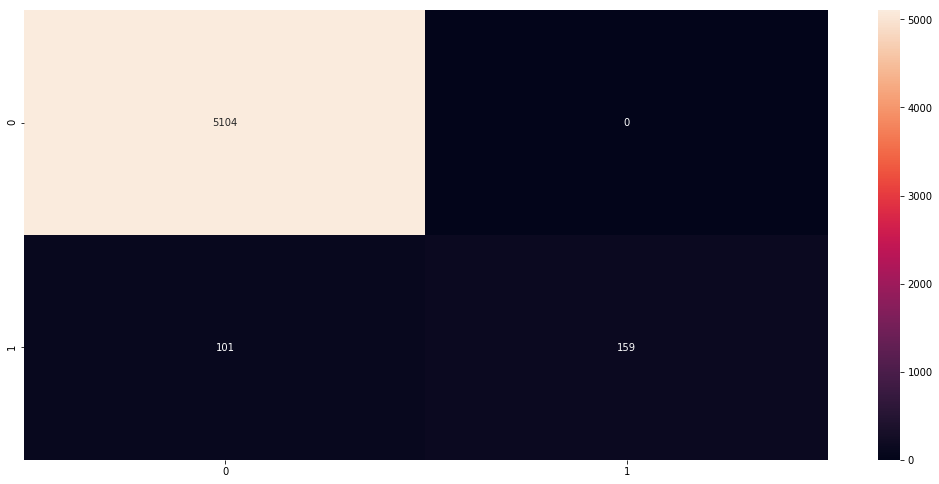

In [83]:
# Plot confusion matrix
c_m_rf1 = confusion_matrix(y_test1, rfc_pred1)
sns.heatmap(c_m_rf1, annot=True, fmt='d') # font size
plt.show()

#### AUC Score for our new Random Forest Model

In [84]:
# AUC Score
metrics.roc_auc_score(y_test1, rfc_pred1)

0.8057692307692308

## In conclusion - by reducing noise in the dataset we increased the F1 score for Class 1 by 11% and improved AUC by 6%.

## The RF model was able to predict fraudulent job postings with an accuracy of 98%.